In [1]:
%cd ..

/home/zarizky/projects/neural-autoregressive-object-co-occurrence


In [2]:
from collections import OrderedDict
from math import log

import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.utils import data
from torchvision import transforms as T
from torchvision.datasets import MNIST
from tqdm.auto import tqdm

from made import MADE, MaskedAutoregressiveLinear

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

torch.manual_seed(0)

made = MADE(
    MaskedAutoregressiveLinear(784, 512, weight_condition=False),
    nn.ReLU(),
    MaskedAutoregressiveLinear(512, 512, weight_condition=False),
    nn.ReLU(),
    MaskedAutoregressiveLinear(512, 784, weight_condition=False),
)

dataset = dict()
dataset["train"] = MNIST("mnist", download=True, train=True, transform=T.ToTensor())
dataset["test"] = MNIST("mnist", download=True, train=False, transform=T.ToTensor())

dataloader = dict()
dataloader["train"] = data.DataLoader(
    dataset["train"], batch_size=128, num_workers=16, shuffle=True, pin_memory=True
)
dataloader["test"] = data.DataLoader(
    dataset["test"], batch_size=128, num_workers=16, shuffle=False, pin_memory=True
)

In [4]:
num_sample_train = 1
num_sample_test = 100
patience_max = 10

made = made.to(device)
opt = optim.Adam(made.parameters(), lr=5e-4)

epochs = 500

record = []
with tqdm(total=epochs, unit="epoch") as pbar:
    patience = 1
    loss_best = torch.inf
    for i in range(epochs):
        pbar.set_description(f"[patience: {patience}/{patience_max}]")

        loss_train = 0
        loss_test = 0

        made.train()
        for inputs, _ in dataloader["train"]:
            inputs = (inputs > 0.5).to(device)
            inputs = inputs.flatten(1).float()
            inputs = inputs.unsqueeze(-1)

            sample = []
            for _ in range(num_sample_train):
                dist = torch.distributions.Bernoulli(logits=made(inputs))
                dist = torch.distributions.Independent(dist, 1)
                sample.append(dist.log_prob(inputs) - log(num_sample_train))
            sample = torch.stack(sample, -1)
            sample.logsumexp(-1).mean().neg().backward()
            opt.step()
            opt.zero_grad()

        with torch.no_grad():
            for inputs, _ in dataloader["train"]:
                inputs = (inputs > 0.5).to(device)
                inputs = inputs.flatten(1).float()
                inputs = inputs.unsqueeze(-1)

                sample = []
                with torch.inference_mode():
                    for _ in range(num_sample_test):
                        dist = torch.distributions.Bernoulli(logits=made(inputs))
                        dist = torch.distributions.Independent(dist, 1)
                        sample.append(dist.log_prob(inputs))
                    sample = torch.stack(sample, -1) - log(num_sample_test)
                    loss = sample.logsumexp(-1).sum().neg()

                loss_train += loss.item()

            for inputs, _ in dataloader["test"]:
                inputs = (inputs > 0.5).to(device)
                inputs = inputs.flatten(1).float()
                inputs = inputs.unsqueeze(-1)

                sample = []
                with torch.inference_mode():
                    for _ in range(num_sample_test):
                        dist = torch.distributions.Bernoulli(logits=made(inputs))
                        dist = torch.distributions.Independent(dist, 1)
                        sample.append(dist.log_prob(inputs))
                    sample = torch.stack(sample, -1) - log(num_sample_test)
                    loss = sample.logsumexp(-1).sum().neg()

                loss_test += loss.item()

        loss_train /= len(dataset["train"])
        loss_test /= len(dataset["test"])

        history = OrderedDict(
            loss=loss_train,
            val_loss=loss_test,
        )

        if loss_best > (loss_current := history["val_loss"]):
            patience = 1
            loss_best = loss_current
        else:
            patience = patience + 1

        record.append(history)

        for key, value in history.items():
            history[key] = str(round(value, 4))

        pbar.set_postfix(history)
        pbar.update()

        if patience > patience_max:
            break

  0%|          | 0/500 [00:00<?, ?epoch/s]

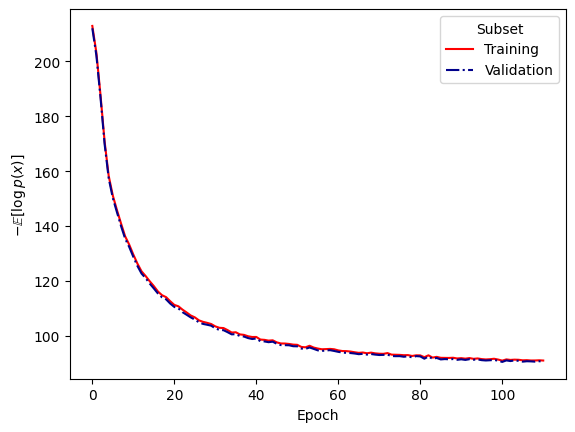

In [5]:
loss = [float(history["loss"]) for history in record]
val_loss = [float(history["val_loss"]) for history in record]

plt.xlabel("Epoch")
plt.ylabel("$-\mathbb{E}[\log p(x)]$")

plt.plot(loss, "-", color="red", label="Training")
plt.plot(val_loss, "-.", color="darkblue", label="Validation")
plt.legend(title="Subset")
plt.show()